In [3]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import requests
import random
import torch.nn.functional as F

# Replace with the URL you copied
url = 'https://raw.githubusercontent.com/jvilchesf/Learning/main/Andrej_karpathy_videos/Makemore/names.txt'

response = requests.get(url)
words = response.text.splitlines()

In [51]:
print(words[:10])

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']


In [52]:
len(words)


32033

In [53]:
#Creating dictionaries
alphabet = sorted(list(set(''.join(words))))
itos = {idx + 1: ch for idx, ch in enumerate(alphabet)} 
itos[0] = '.'
stoi = {s : i  for i, s in itos.items()} 


In [54]:
#Creating the dataset

block_size = 3
vocab_size = len(itos)
def create_dataset(words): 
    X = []
    Y = []
    for word in words:
        context = block_size * [0]

        for i in word + '.':
            idx = stoi[i]
            Y.append(idx)
            X.append(context)
            #print(f"{context} ---> {i}")
            context = context[1:] + [idx]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X,Y

random.seed(42)
random.shuffle(words)
n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)

Xtr, Ytr = create_dataset(words[:n1])
Xdev, Ydev = create_dataset(words[n1:n2])
Xte, Yte = create_dataset(words[n2:])

print (Xtr.shape, Ytr.shape)    
print (Xdev.shape, Ydev.shape)
print (Xte.shape, Yte.shape)

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [154]:
#Define Class Linear, BatchNorm1d and tanh

class Linear:

    def __init__(self, fanin, fanout, bias = True):
        self.weights = torch.randn(fanin, fanout) / fanin**0.5
        self.bias = torch.zeros(fanout) if bias else None

    def __call__(self, x):
        self.out = x @ self.weights
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weights] if self.bias is None else [self.weights, self.bias]
    
class BatchNorm1d:

    def __init__(self, num_features, momentum = 0.1, epsilom = 1e-5):
        self.momentum = momentum
        self.epsilom = epsilom
        self.training = True
        #parameters train with backpropagation
        self.gamma = torch.ones(num_features)
        self.beta = torch.zeros(num_features)
        #parameters not train with backpropagation
        self.running_mean = torch.zeros(num_features)
        self.running_var = torch.ones(num_features)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim = True) #batch mean
            xvar = x.var(0, keepdim = True) #batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var

        x_hat = (x - xmean) / torch.sqrt(xvar + self.epsilom) # normalize to unit variance
        self.out = self.gamma * x_hat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

class tanh:
    def __call__(self, x):
        self.out = x.tanh()
        return self.out
    
    def parameters(self):
        return []

In [176]:
#Define the model
n_embedding = 10
n_hidden = 100

g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embedding),            generator=g)  

layers=[
    Linear(block_size * n_embedding, n_hidden, bias = False),  BatchNorm1d(n_hidden), tanh(),
    Linear(                n_hidden, n_hidden, bias = False),  BatchNorm1d(n_hidden), tanh(),
    Linear(                n_hidden, n_hidden, bias = False),  BatchNorm1d(n_hidden), tanh(),
    Linear(                n_hidden, n_hidden, bias = False),  BatchNorm1d(n_hidden), tanh(),
    Linear(                n_hidden, n_hidden, bias = False),  BatchNorm1d(n_hidden), tanh(),
    Linear(                n_hidden, vocab_size, bias = False),BatchNorm1d(vocab_size)
]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weights *=  5/3

#Set parameters to train
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47024


In [177]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for _ in range(max_steps):

    idx = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb= Xtr[idx], Ytr[idx]

    # forward pass
    emb = C[Xb] # lookup
    X = emb.view(emb.shape[0], -1) # flattens
    for layer in layers:
        X = layer(X)
    loss = F.cross_entropy(X, Yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()
  
    # update
    lr = 0.1 if _ < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

# track stats
    if _ % 10000 == 0: # print every once in a while
        print(f'{_:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    if _ >= 1000:
        break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2873


layer 2 (      tanh): mean -0.00, std 0.64, saturated: 3.09%
layer 5 (      tanh): mean -0.00, std 0.64, saturated: 2.81%
layer 8 (      tanh): mean +0.00, std 0.65, saturated: 2.69%
layer 11 (      tanh): mean +0.00, std 0.65, saturated: 2.38%
layer 14 (      tanh): mean -0.00, std 0.65, saturated: 2.03%


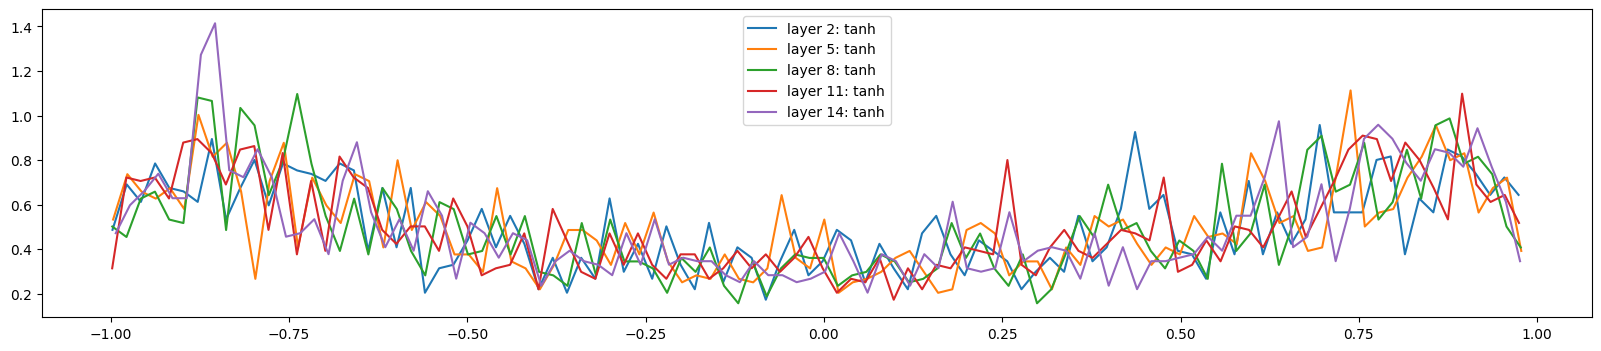

In [178]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, tanh): 
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy , hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i}: {layer.__class__.__name__}')
plt.legend(legends)

layer 2 (      tanh): mean -0.00, std 0.64, saturated: 3.09%
layer 5 (      tanh): mean -0.00, std 0.64, saturated: 2.81%
layer 8 (      tanh): mean +0.00, std 0.65, saturated: 2.69%
layer 11 (      tanh): mean +0.00, std 0.65, saturated: 2.38%
layer 14 (      tanh): mean -0.00, std 0.65, saturated: 2.03%


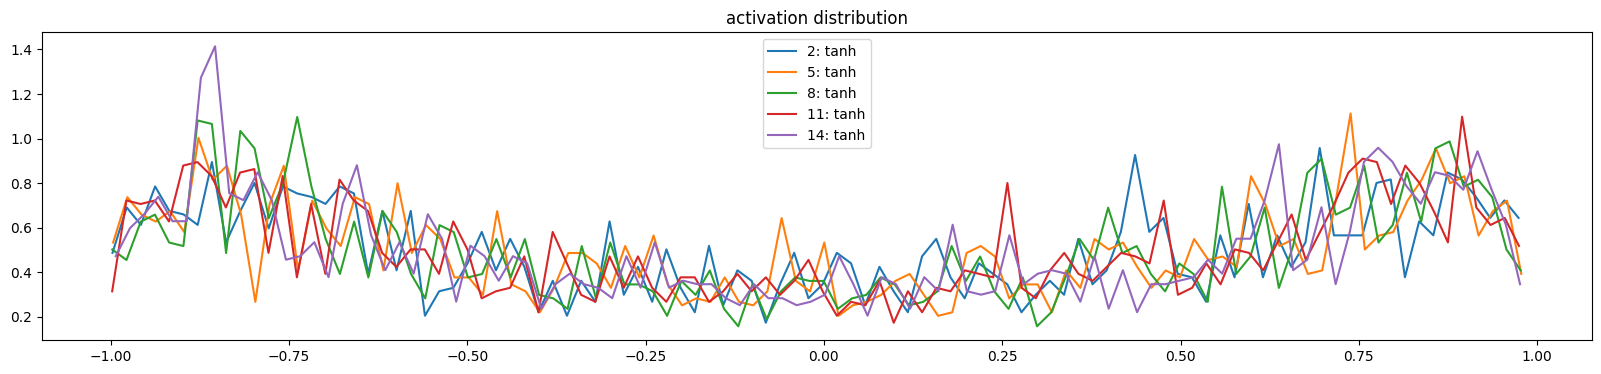

In [179]:
#visualize histograms
plt.figure(figsize=(20, 4))
legends = []
for i , layer in enumerate(layers[:-1]):
    if isinstance(layer,tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True);
        plt.plot(hx[:-1].detach(), hy.detach());
        legends.append(f"{i}: {layer.__class__.__name__}")
        plt.legend(legends, loc='upper center')
    plt.title('activation distribution')


layer 2 (      tanh): mean +0.000000 std 3.572661e-03
layer 5 (      tanh): mean +0.000000 std 3.110193e-03
layer 8 (      tanh): mean +0.000000 std 2.825683e-03
layer 11 (      tanh): mean -0.000000 std 2.754746e-03
layer 14 (      tanh): mean +0.000000 std 2.584745e-03


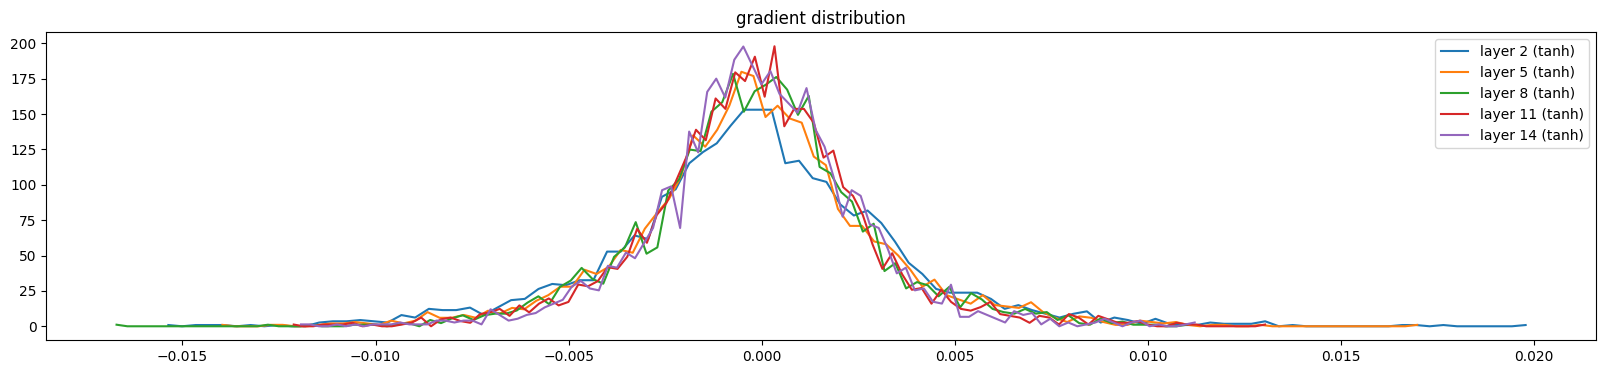

In [180]:
#gradient distribution histograms
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers):
    if isinstance(layer, tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f std %e' % (i, layer.__class__.__name__, t.mean(), t.std())) 
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
        plt.legend(legends);
plt.title('gradient distribution');


weight   (27, 10) | mean -0.000000 | std 8.160461e-03 | grad:data ratio 8.152205e-03
weight  (30, 100) | mean +0.000167 | std 7.850514e-03 | grad:data ratio 2.604358e-02
weight (100, 100) | mean -0.000024 | std 6.409700e-03 | grad:data ratio 3.798823e-02
weight (100, 100) | mean +0.000070 | std 5.925511e-03 | grad:data ratio 3.545789e-02
weight (100, 100) | mean +0.000003 | std 5.448655e-03 | grad:data ratio 3.278998e-02
weight (100, 100) | mean -0.000047 | std 5.182790e-03 | grad:data ratio 3.096296e-02
weight  (100, 27) | mean -0.000030 | std 9.147273e-03 | grad:data ratio 5.422400e-02


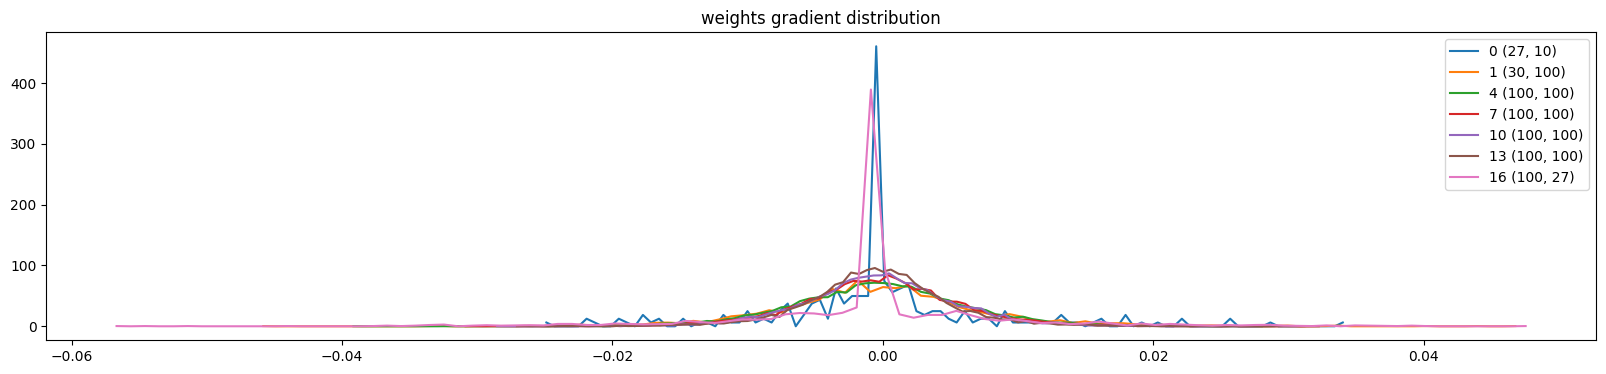

In [181]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

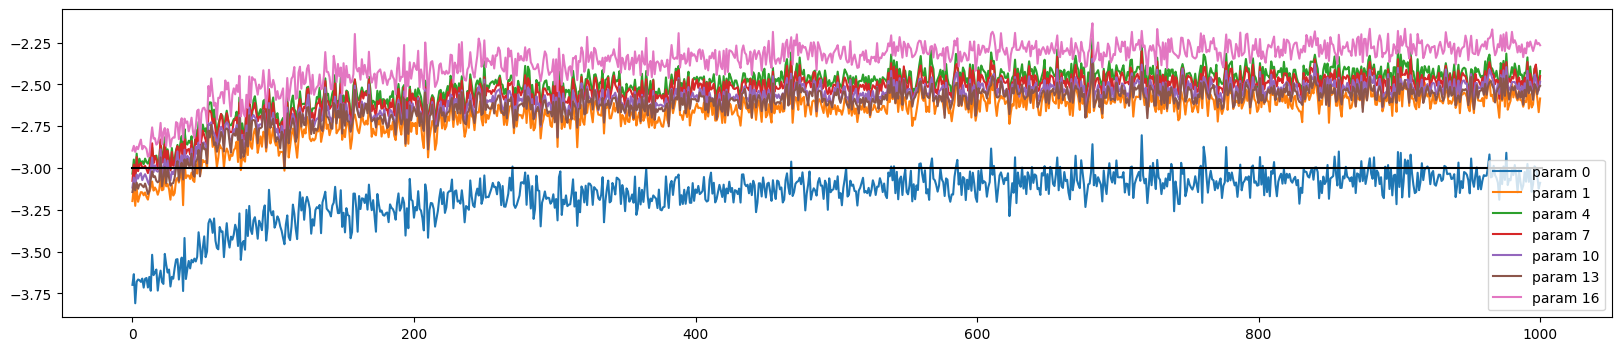

In [182]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [174]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 2.518329381942749
val 2.5146379470825195


In [13]:
#Model starting with a high loss

#Train | loss = 2.319223642349243
#Dev | loss = 2.3185811042785645
#Test | loss = 2.315457344055176

#Model with smaller w2 and b2
#Train | loss = 2.306452512741089
#Dev | loss = 2.3043744564056396
#Test | loss = 2.304983139038086

#Model multiplying the w1 by (5/3) * (block_size * n_embd) ** 0.5
#Train | loss = 2.0492982864379883
#Dev | loss = 2.1094372272491455
#Test | loss = 2.105741262435913

#Model with batch normalization step before train 
#Train | loss = 2.05985498428344733
#Dev | loss = 2.104597330093384
#Test | loss = 2.104496955871582

#Model with batch normalization running traing
#Train | loss = 2.059568166732788
#Dev | loss = 2.1049513816833496
#Test | loss = 2.1046841144561768

In [14]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

zaidy.
ade.
rose.
brith.
hal.
oanne.
rayy.
keymon.
abby.
arah.
lian.
kallo.
luiderleth.
manahurrahei.
majadyn.
ash.
blopella.
shreniya.
presten.
hendra.
